In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import numpy as np
import pandas as pd
import scipy
import altair as alt
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from interaction_effects.marginal import MarginalExplainer
from interaction_effects.plot import summary_plot
import read_data

In [3]:
tf.enable_eager_execution()

In [4]:
X_train, X_test, y_train, y_test = read_data.load_data()

In [5]:
X_train.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
286,0.515843,0.151973,-0.823411,0.517860,-0.163186,2,1,0,1,0,1,0,0,0,1,0,1,0,0
102,0.953857,0.483800,-0.994193,1.270945,-0.860600,2,0,0,0,1,1,0,0,0,1,0,1,0,0
242,1.063361,0.760322,-0.671604,-0.811113,0.882934,2,1,0,0,0,1,0,1,0,0,1,0,1,0
65,-2.112242,0.373191,-1.221903,1.403842,0.359874,0,0,0,0,0,1,0,0,0,1,0,1,0,0
35,-0.907703,0.594409,-1.335758,0.429262,0.359874,0,0,1,0,0,1,0,1,1,0,0,1,0,0


In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

history = model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=0)
score = model.evaluate(X_train, y_train, batch_size=128, verbose=0)
print('Train Loss: {:.4f}, Train Accuracy: {:.4f}, Train AUC: {:.4f}'.format(score[0], score[1], score[2]))
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
print('Test Loss: {:.4f}, Test Accuracy: {:.4f}, Test AUC: {:.4f}'.format(score[0], score[1], score[2]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train Loss: 0.3004, Train Accuracy: 0.8967, Train AUC: 0.9443
Test Loss: 0.4018, Test Accuracy: 0.8361, Test AUC: 0.9005


In [7]:
pred_labels = []
for i in range(0, len(X_test), 128):
    pred_labels.append(model.predict(X_test[i:i+128].values))
pred_labels = np.concatenate(pred_labels, axis=0)
pred_labels = np.squeeze(pred_labels)

In [8]:
mat = confusion_matrix(y_test, (pred_labels > 0.5).astype(int))
total = np.sum(mat)

sensitivity = mat[0, 0] / (mat[0, 0] + mat[1, 0])
specificity = mat[1, 1] / (mat[1, 1] + mat[0, 1])
print('Sensitivity: {:.4f}, Specificity: {:.4f}'.format(sensitivity, specificity))

Sensitivity: 0.8571, Specificity: 0.8077


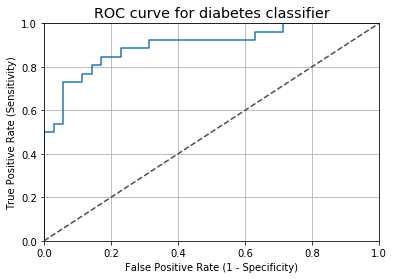

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, pred_labels)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [10]:
try:
    sample_shap = np.load('sample_shap.npy')
except FileNotFoundError:
    model_func = lambda x: model(x).numpy()
    sample_explainer = shap.SamplingExplainer(model_func, X_train)
    sample_shap      = sample_explainer.shap_values(X_test)
    np.save('sample_shap.npy', sample_shap)

In [11]:
try:
    primal_effects = np.load('primal_effects.npy')
except FileNotFoundError:
    primal_explainer = MarginalExplainer(model, X_train.values, X_train.shape[0])
    primal_effects   = primal_explainer.explain(X_test.values, batch_size=128, verbose=True)
    np.save('primal_effects.npy', primal_effects)

In [12]:
interaction_effects = sample_shap - primal_effects

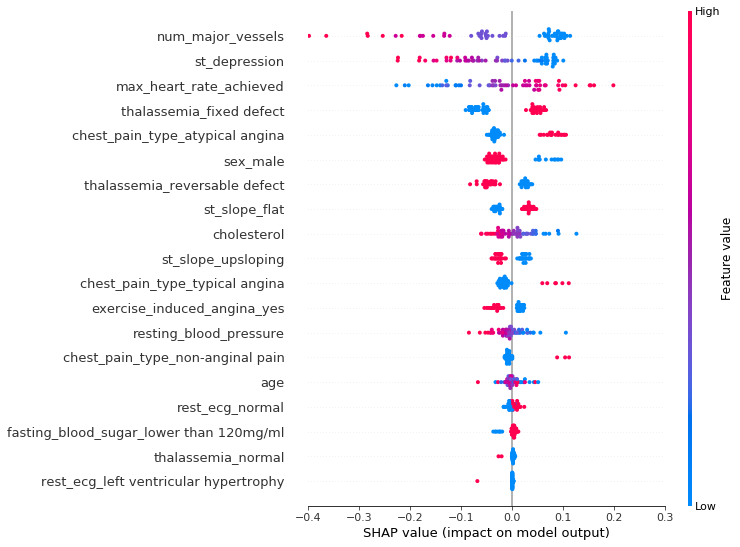

In [26]:
summary_plot(sample_shap, X_test, xlim=(-0.4, 0.3))

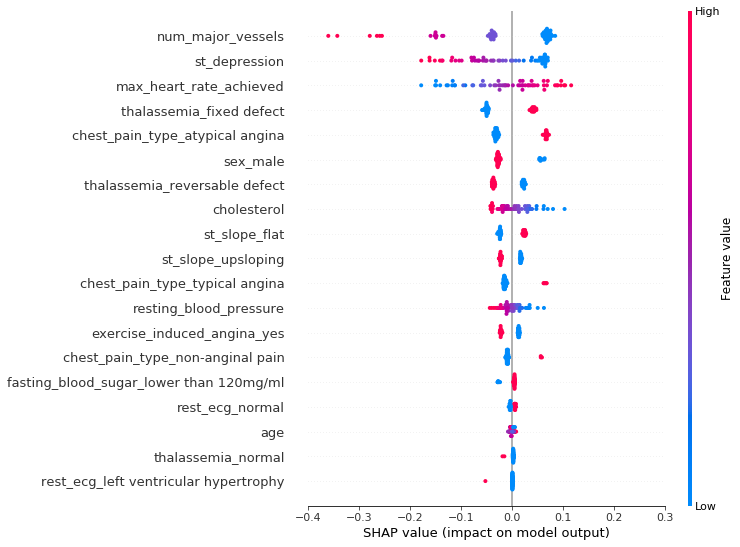

In [27]:
summary_plot(primal_effects, X_test, xlim=(-0.4, 0.3))

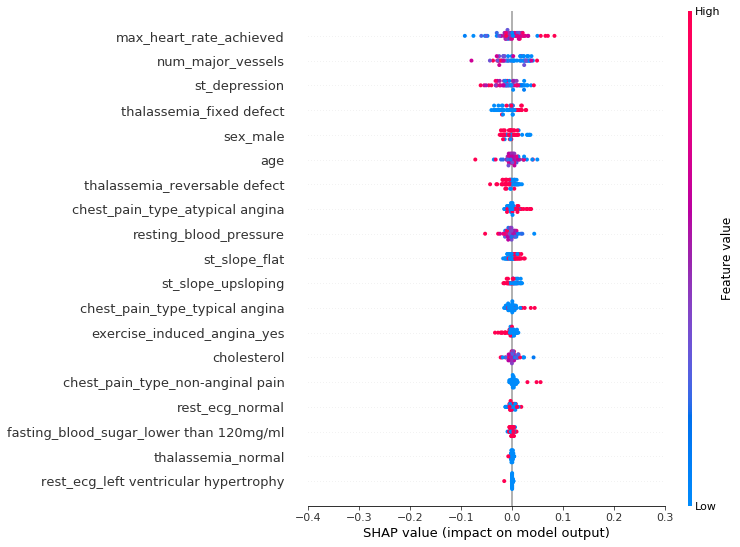

In [29]:
summary_plot(interaction_effects, X_test, xlim=(-0.4, 0.3))

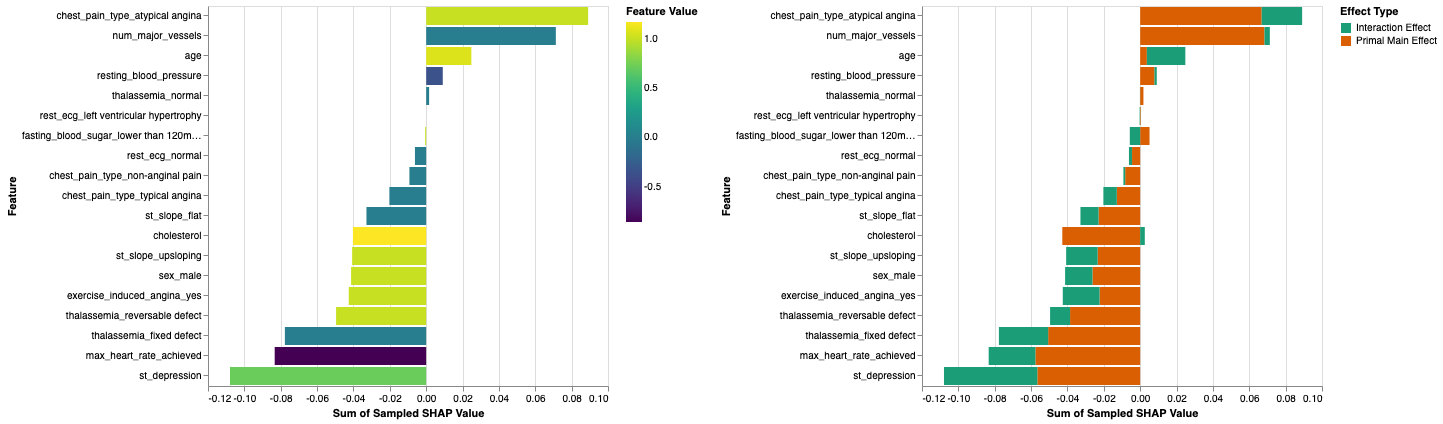

In [16]:
patient_index = 2
ind_df = pd.DataFrame({
    'Primal Main Effect': primal_effects[patient_index],
    'Interaction Effect': sample_shap[patient_index] - primal_effects[patient_index],
    'Feature': X_test.columns,
    'Feature Value': X_test.loc[X_test.index[patient_index]]
})

melted_df = pd.melt(ind_df, id_vars=['Feature', 'Feature Value'], value_name='Sampled SHAP Value', var_name='Effect Type')

base = alt.Chart(melted_df).mark_bar().encode(
    alt.X('sum(Sampled SHAP Value):Q'),
    alt.Y('Feature:N', sort=alt.EncodingSortField(
            field="Sampled SHAP Value",
            order="descending" 
        ))
)

base_descending = base.transform_window(
    rank='rank(sum(Sampled SHAP Value))',
    sort=[alt.SortField('sum(Sampled SHAP Value)', order='descending')]
)

base_ascending = base.transform_window(
    rank='rank(sum(Sampled SHAP Value))',
    sort=[alt.SortField('sum(Sampled SHAP Value)', order='ascending')]
)

(base_descending.encode(
    alt.Color('Feature Value:Q', scale=alt.Scale(scheme='viridis'))
))  | base_descending.encode(
    alt.Color('Effect Type:N', scale=alt.Scale(scheme='dark2'))
)

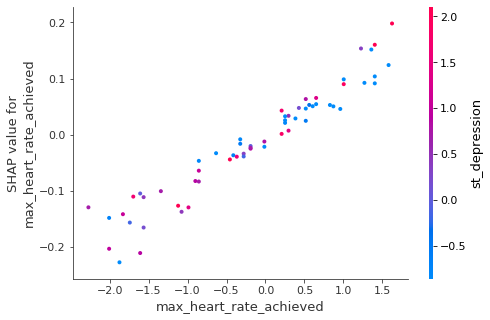

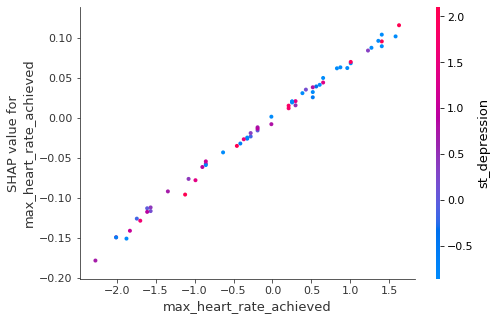

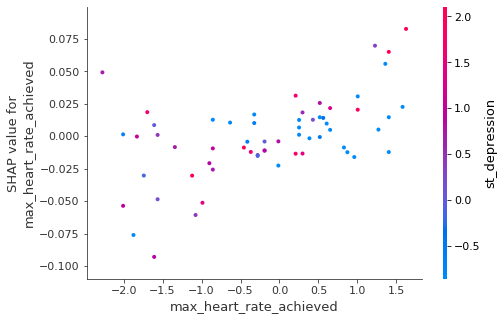

In [21]:
feature = 'max_heart_rate_achieved'
interaction_feature = 'st_depression'
shap.dependence_plot(feature, sample_shap, X_test, interaction_index=interaction_feature)
shap.dependence_plot(feature, primal_effects, X_test, interaction_index=interaction_feature)
shap.dependence_plot(feature, interaction_effects, X_test, interaction_index=interaction_feature)

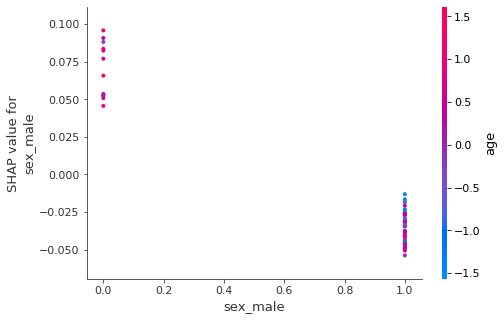

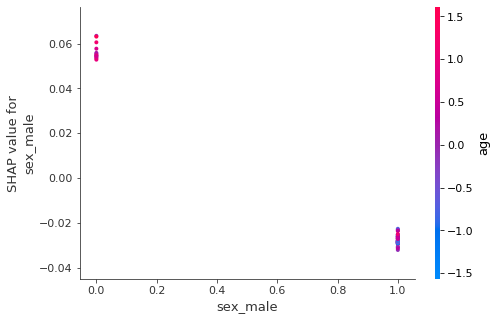

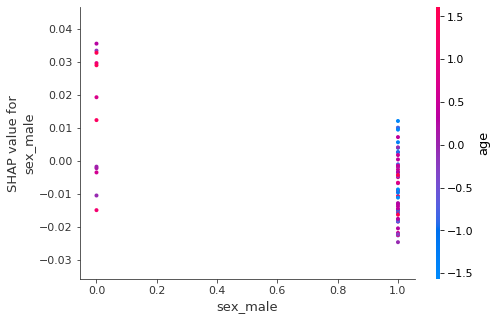

In [34]:
feature = 'sex_male'
interaction_feature = 'age'
shap.dependence_plot(feature, sample_shap, X_test, interaction_index=interaction_feature)
shap.dependence_plot(feature, primal_effects, X_test, interaction_index=interaction_feature)
shap.dependence_plot(feature, interaction_effects, X_test, interaction_index=interaction_feature)

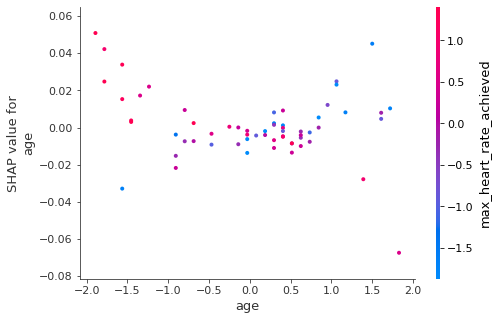

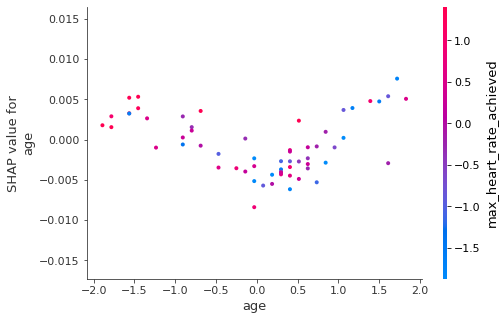

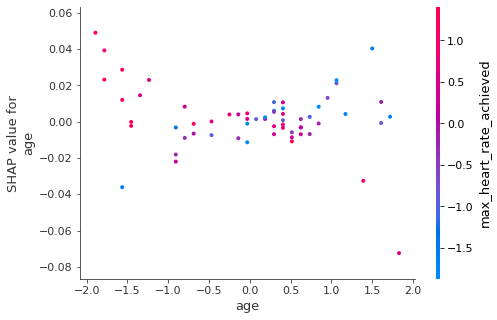

In [18]:
feature = 'age'
interaction_feature = 'max_heart_rate_achieved'
shap.dependence_plot(feature, sample_shap, X_test, interaction_index=interaction_feature)
shap.dependence_plot(feature, primal_effects, X_test, interaction_index=interaction_feature)
shap.dependence_plot(feature, interaction_effects, X_test, interaction_index=interaction_feature)

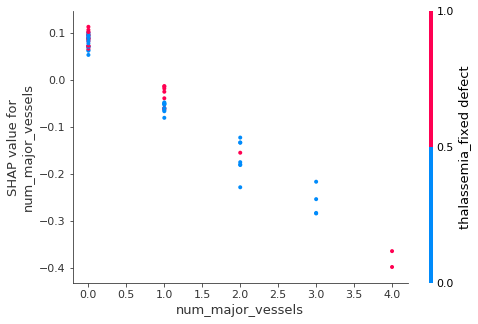

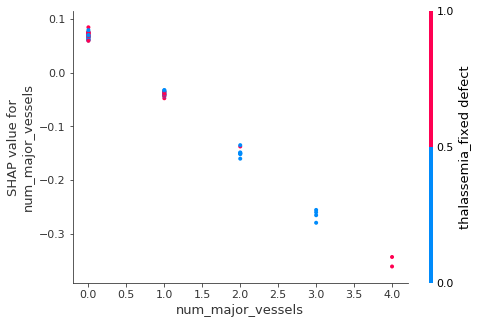

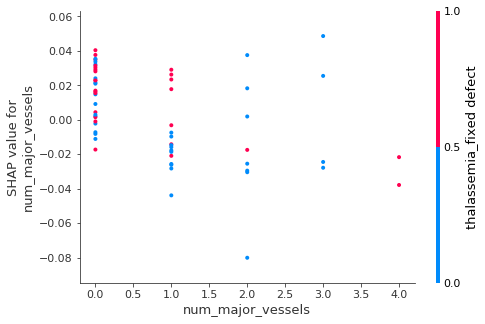

In [23]:
feature = 'num_major_vessels'
interaction_feature = 'thalassemia_fixed defect'
shap.dependence_plot(feature, sample_shap, X_test, interaction_index=interaction_feature)
shap.dependence_plot(feature, primal_effects, X_test, interaction_index=interaction_feature)
shap.dependence_plot(feature, interaction_effects, X_test, interaction_index=interaction_feature)